In [1]:
# import packages
import matplotlib.pyplot as pl
import scanpy as sc
import scvelo as scv
import loompy as lmp
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import cellrank as cr
import warnings
import seaborn as sns
import os
import sys
from anndata import AnnData


# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
#set color palette
colors = sns.color_palette('bright', 9)
colors
TNcdict = {'Tumor Corticotrophs':colors[3], 'Normal Corticotrophs':colors[0], "FSC":colors[4]}
ct_dict = {"corticotrophs": colors[3],
          "somatotrophs": colors[0],
          "lactotrophs": colors[1],
          "gonadotrophs": colors[2],
          "fsc": colors[4],
          "endothelial": colors[5],
          "pericytes": colors[6],
          "leukocyte": colors[7],
          "Unknown": colors[8]}


color_macro = ["tab:brown", "tab:red","tab:gray", "tab:orange", "tab:purple", "tab:pink", "tab:blue", "tab:green"]

color_macro


['tab:brown',
 'tab:red',
 'tab:gray',
 'tab:orange',
 'tab:purple',
 'tab:pink',
 'tab:blue',
 'tab:green']

In [3]:
colors

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0)]

# Load and Merge Tumor Data with Spliced and Unspliced Counts

In [4]:
adata=scv.read("/Users/bhattda/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/new_tumor_data/P3_T_GEX.h5ad")
ldata=scv.read("/Users/bhattda/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/new_tumor_data/P3_T_outs_gex_possorted_bam_L1F6L.loom",cache=True)
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(ldata)

adata = scv.utils.merge(adata, ldata)
#save combined anndata file 
sc.write("adata_original.h5ad", adata) 

... writing an h5ad cache file to speedup reading next time


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# All Cell Type Analysis

<font size="5">Preproccess data and compute UMAP</font>

extracting highly variable genes
    finished (0:00:00)


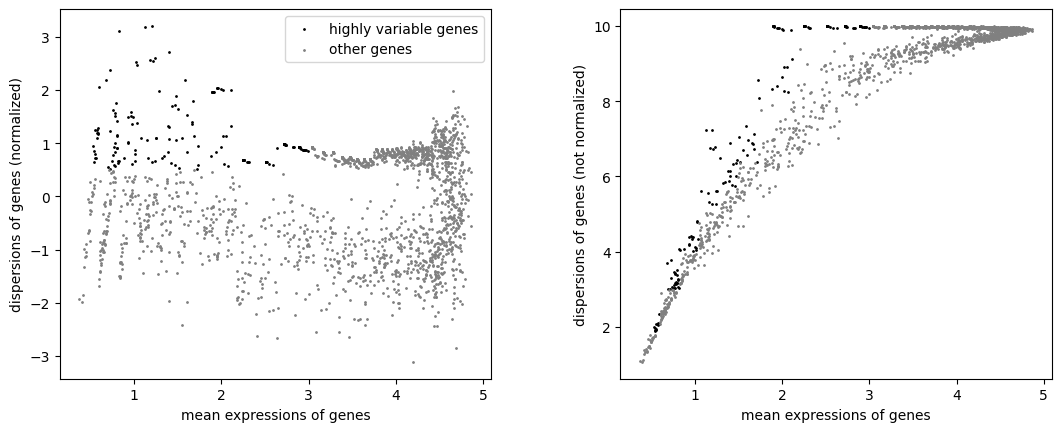

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:08)
computing UMAP
    finished (0:00:08)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


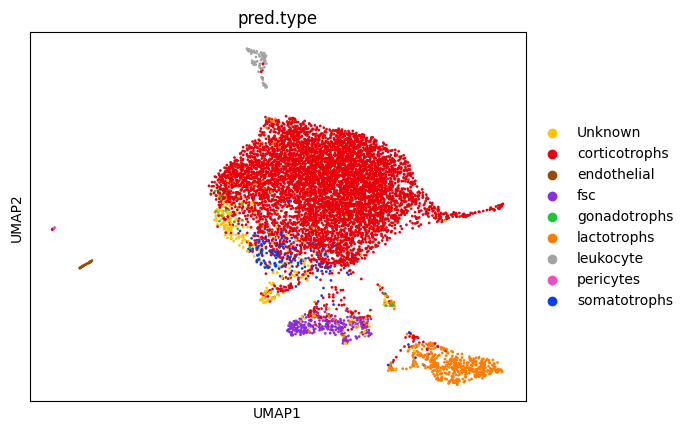

In [5]:
adata= sc.read_h5ad("adata_original.h5ad")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='pred.type', palette=ct_dict)

<font size="5">Compute RNA Velocity</font>

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts =2, n_top_genes=2000)
scv.pp.moments(adata,n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode= "dynamical")
scv.tl.velocity_graph(adata)

Filtered out 623 genes that are detected 2 counts (shared).
Normalized count data: spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/8 cores)


  0%|          | 0/54 [00:00<?, ?gene/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/7755 [00:00<?, ?cells/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


<font size="5">Display RNA Velocity</font>

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


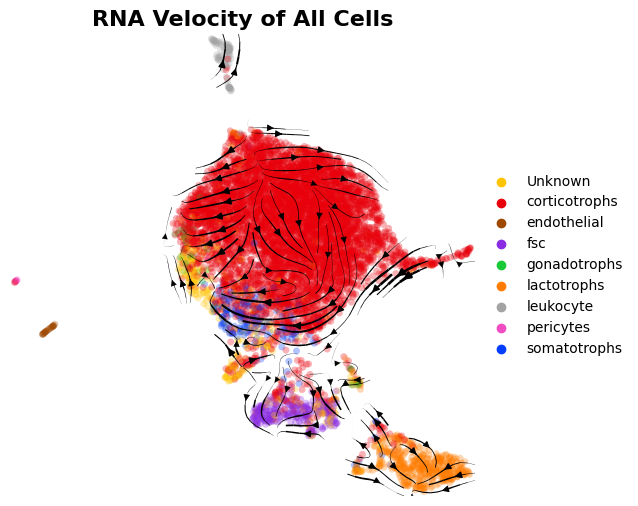

In [7]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = scv.pl.velocity_embedding_stream(adata, basis= "umap", color="pred.type",  size = 100, dpi =600,
                                            legend_loc="top right", ax= ax1, show = False, palette=ct_dict)
ax1.set_title("RNA Velocity of All Cells", fontweight="bold", fontsize=16)
    
pl.savefig("All_Cell_RNA_Velocity.png")

# FSC and Corticotrophs Analysis

<font size="5">Import, Filter for FSC and Coritcotrophs,  and Preprocess Data</font>

In [8]:
adata= sc.read_h5ad("adata_original.h5ad")
adata = adata[(adata.obs['pred.type'] == "corticotrophs") | (adata.obs['pred.type'] == "fsc")    ]
adata

View of AnnData object with n_obs × n_vars = 6598 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'anno', 'percent.mt', 'pANN_0.25_0.09_0', 'DF.classifications_0.25_0.09_0', 'pred.type', 'RNA_snn_res.0.5', 'seurat_clusters', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances'

extracting highly variable genes
    finished (0:00:00)


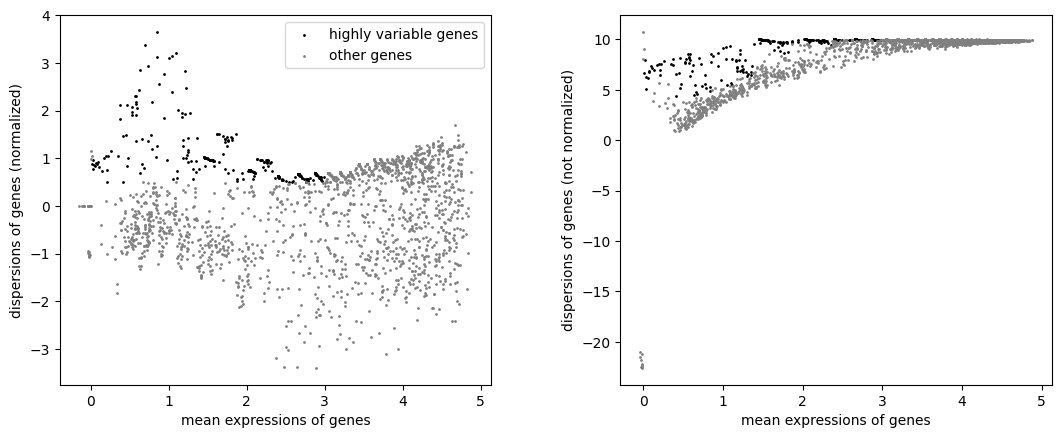

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:01)
computing UMAP
    finished (0:00:07)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


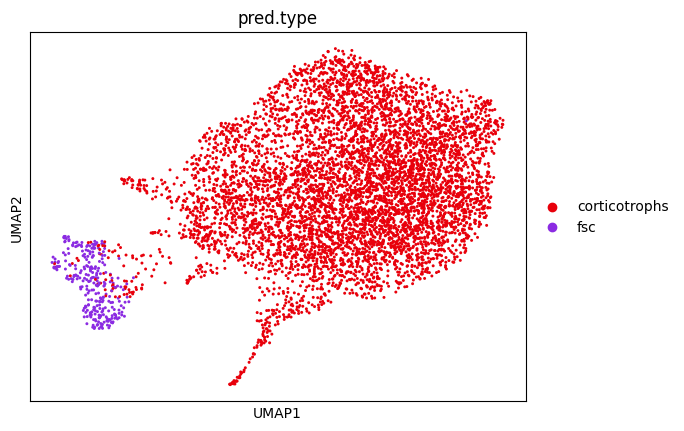

In [10]:
#Preproccess data and compute UMAP
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='pred.type', palette=ct_dict)

<font size="5">Compute RNA Velocity</font>

In [12]:
scv.pp.filter_and_normalize(adata, min_shared_counts =2, n_top_genes=2000)
scv.pp.moments(adata,n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode= "dynamical")
scv.tl.velocity_graph(adata)

Filtered out 869 genes that are detected 2 counts (shared).
Normalized count data: spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/8 cores)


  0%|          | 0/60 [00:00<?, ?gene/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:12) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/6598 [00:00<?, ?cells/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


<font size="5">Display RNA Velocity</font>

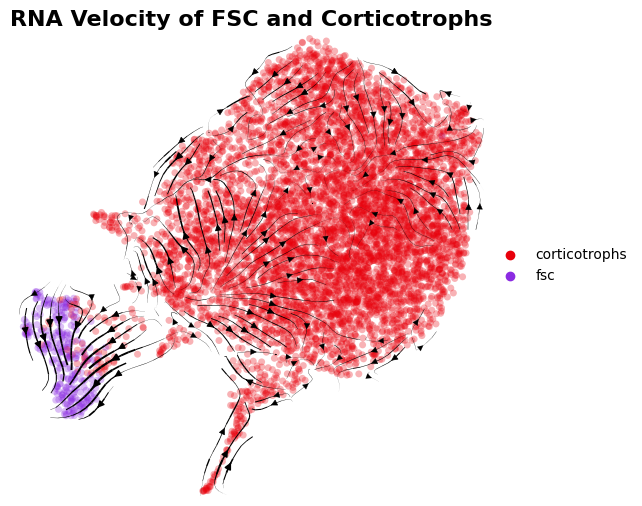

In [16]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = scv.pl.velocity_embedding_stream(adata, basis= "umap", color="pred.type",  size = 100, dpi =600,
                                            legend_loc="top right", ax= ax1, show = False, palette=ct_dict)
ax1.set_title("RNA Velocity of FSC and Corticotrophs", fontweight="bold", fontsize=16)

    
pl.savefig("FSC_and_Corticotrophs_RNA_Velocity.png")

# Corticotrophs Analysis

<font size="5">Import, Filter for Coritcotrophs, and Preprocess Data</font>

In [17]:
adata= sc.read_h5ad("adata_original.h5ad")
adata = adata[(adata.obs['pred.type'] == "corticotrophs")  ]
adata

View of AnnData object with n_obs × n_vars = 6320 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'anno', 'percent.mt', 'pANN_0.25_0.09_0', 'DF.classifications_0.25_0.09_0', 'pred.type', 'RNA_snn_res.0.5', 'seurat_clusters', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances'

extracting highly variable genes
    finished (0:00:00)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


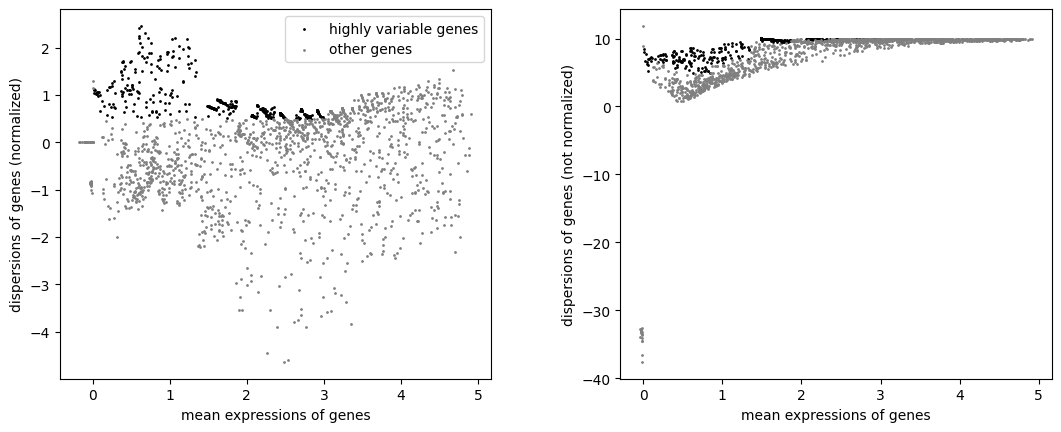

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:01)
computing UMAP
    finished (0:00:07)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


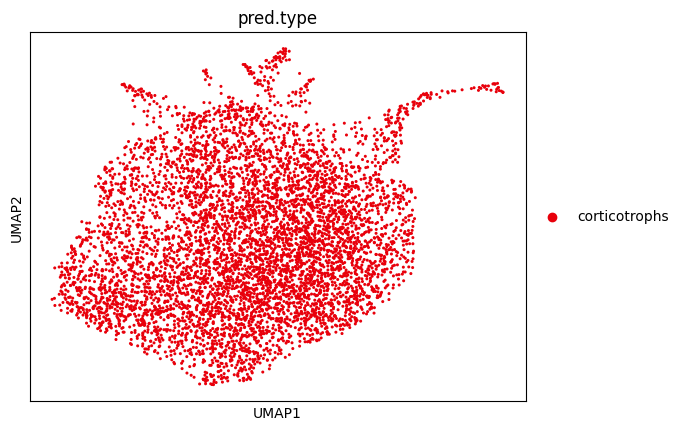

In [18]:
#preprocess and compute UMAP
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='pred.type', palette=ct_dict)

<font size="5">Compute RNA Velocity</font>

In [19]:
scv.pp.filter_and_normalize(adata, min_shared_counts =20, n_top_genes=2000)
scv.pp.moments(adata,n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode= "dynamical")
scv.tl.velocity_graph(adata)

Filtered out 1498 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/8 cores)


  0%|          | 0/25 [00:00<?, ?gene/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/6320 [00:00<?, ?cells/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [20]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()


Computing transition matrix using `'deterministic'` model


  0%|          | 0/6320 [00:00<?, ?cell/s]

Using `softmax_scale=2.0920`


  0%|          | 0/6320 [00:00<?, ?cell/s]

    Finish (0:00:02)


VelocityKernel[n=6320, model='deterministic', similarity='correlation', softmax_scale=2.092]

<font size="5">Display RNA Velocity</font>

Using precomputed projection `adata.obsm['T_fwd_umap']`


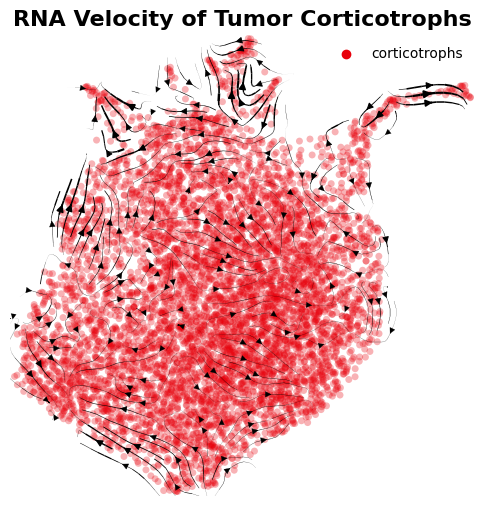

In [23]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = vk.plot_projection( color="pred.type", size = 100, 
                   legend_loc='best',fontsize=16, legend_fontoutline = 5, ax= ax1, show= False,palette=ct_dict)
ax1.set_title("RNA Velocity of Tumor Corticotrophs", fontweight="bold", fontsize=16)
pl.savefig("Corticotrophs_RNA_Velocity.png")


Using precomputed projection `adata.obsm['T_fwd_umap']`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


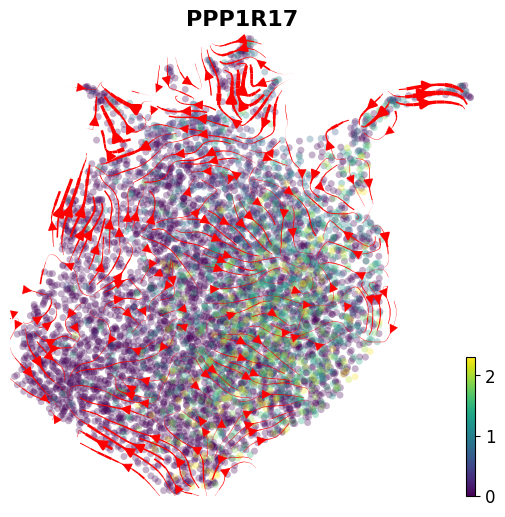

In [53]:
#embed RNA velocity over UMAP of gene expression of PPP1R17
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = vk.plot_projection( color="PPP1R17", size = 100, 
                   legend_loc='best',fontsize=16, legend_fontoutline = 5, ax= ax1, show= False, vmax = 2.3, arrow_size=1.5, linewidth= 2,arrow_color="red", arrow_style = "-|>")
ax1.set_title("PPP1R17", fontweight="bold", fontsize=16)
pl.savefig("PPP1R17_RNA_Velocity.png")

Using precomputed projection `adata.obsm['T_fwd_umap']`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


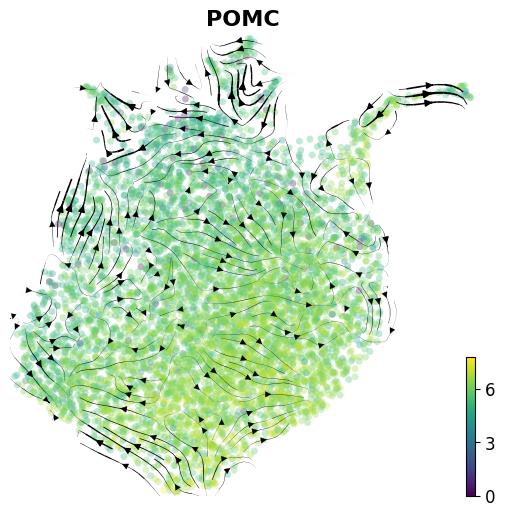

In [27]:
#embed RNA velocity over UMAP of gene expression of POMC
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = vk.plot_projection( color="POMC", size = 100, 
                   legend_loc='best',fontsize=16, legend_fontoutline = 5, ax= ax1, show= False)
ax1.set_title("POMC", fontweight="bold", fontsize=16)
pl.savefig("POMC_RNA_Velocity.png")

Using precomputed projection `adata.obsm['T_fwd_umap']`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


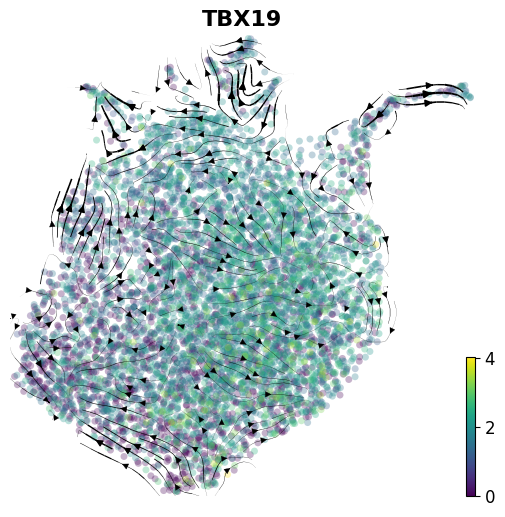

In [28]:
#embed RNA velocity over UMAP of gene expression of TBX19
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = vk.plot_projection( color="TBX19", size = 100, 
                   legend_loc='best',fontsize=16, legend_fontoutline = 5, ax= ax1, show= False)
ax1.set_title("TBX19", fontweight="bold", fontsize=16)
pl.savefig("TBX19_RNA_Velocity.png")

In [29]:
g = cr.estimators.GPCCA(vk)
print(g)


GPCCA[kernel=VelocityKernel[n=6320], initial_states=None, terminal_states=None]


<font size="5">Compute Macrostates</font>

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:56)
Computing `7` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


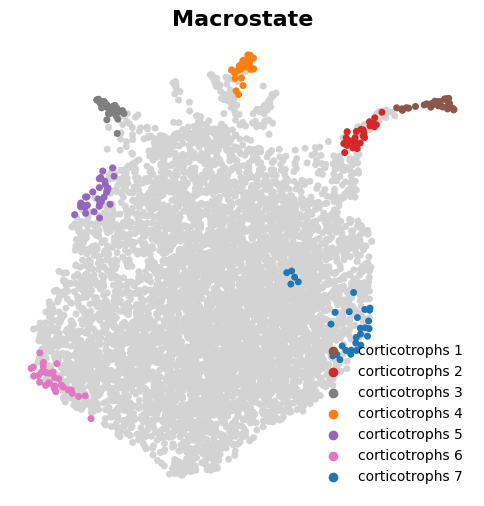

In [31]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
g.fit(cluster_key="pred.type", n_states=7)
fig_kwargs = {"which":"all", 'legend_loc': 'best', 'discrete': True,'dpi':600, 
              'size': 100, "palette":color_macro, "ax":ax1, "show":False}
ax1_dict = g.plot_macrostates(**fig_kwargs)
ax1.set_title("Macrostate", fontweight="bold", fontsize=16)
pl.savefig("Macrostate.png")

In [33]:
adata.obs["macrostates"] = g.macrostates
g.macrostates_memberships.colors = color_macro[0:7]

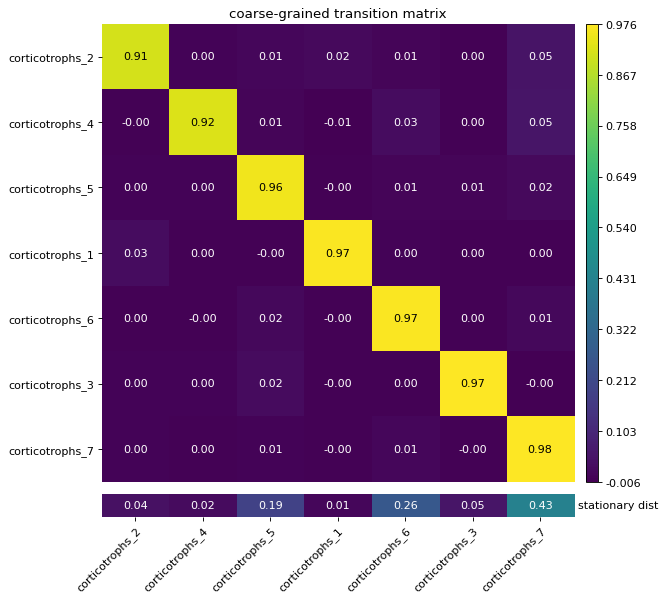

In [34]:
g.plot_coarse_T(save="macrostate_transition_matix.png")

<font size="5">Compute Terminal State</font>

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


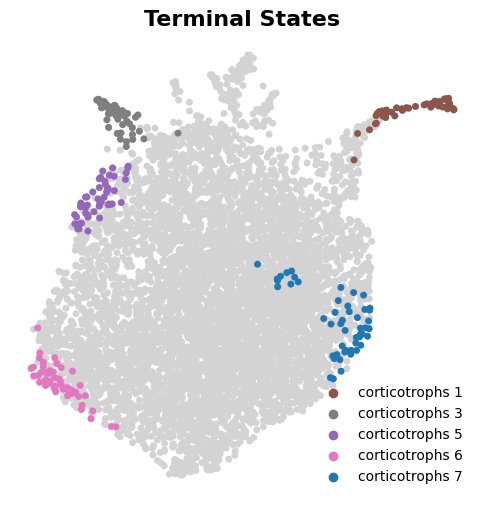

In [35]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
g.predict_terminal_states(stability_threshold=0.95, n_cells=50, allow_overlap=True )
fig_kwargs = {"which":"terminal", 'legend_loc': 'best', 'discrete': True, 'dpi':600, 'size': 100, 
              "ax":ax1, "show":False}
g.plot_macrostates(**fig_kwargs)
ax1.set_title("Terminal States", fontweight="bold", fontsize=16)
pl.savefig("Terminal_States.png")

<font size="5">Compute Initial State</font>

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


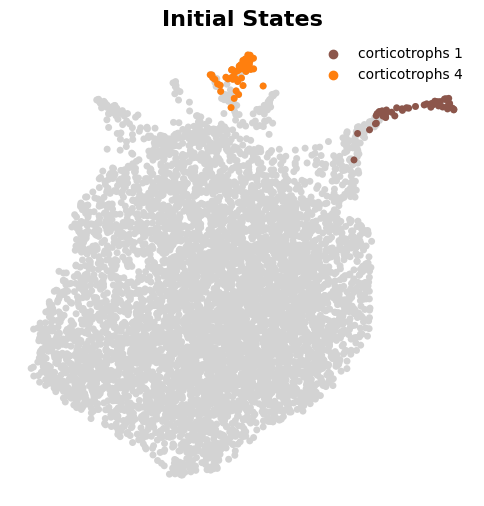

In [38]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
g.predict_initial_states(n_states=2, n_cells= 50, allow_overlap=True)
fig_kwargs = {"which":"initial", 'legend_loc': 'best', 'discrete': True, 'dpi':600, 
              'size': 100, "ax":ax1, "show":False}

g.plot_macrostates(**fig_kwargs)
ax1.set_title("Initial States", fontweight="bold", fontsize=16)
pl.savefig("Initial_States.png", dpi=600)

<font size="5">Compute Fate Probabilities</font>

Computing fate probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/5 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_al

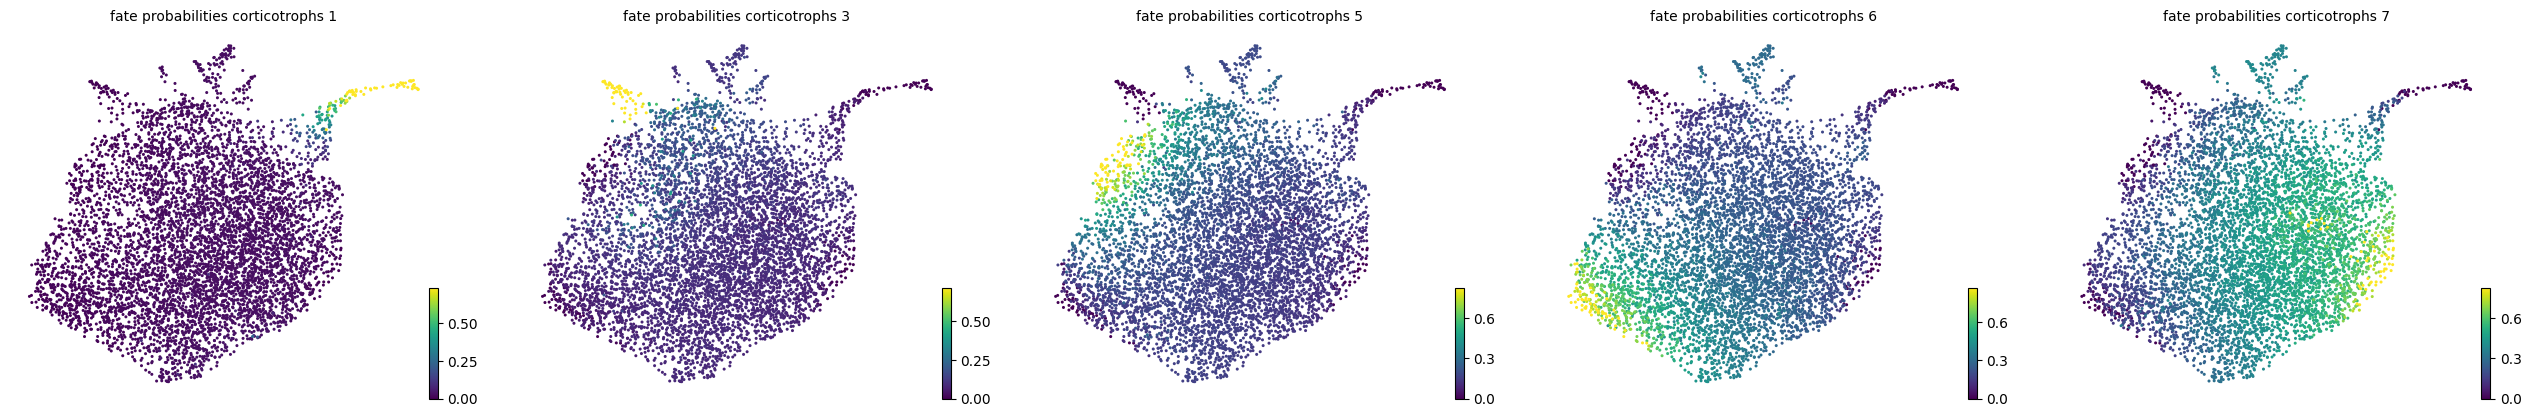

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


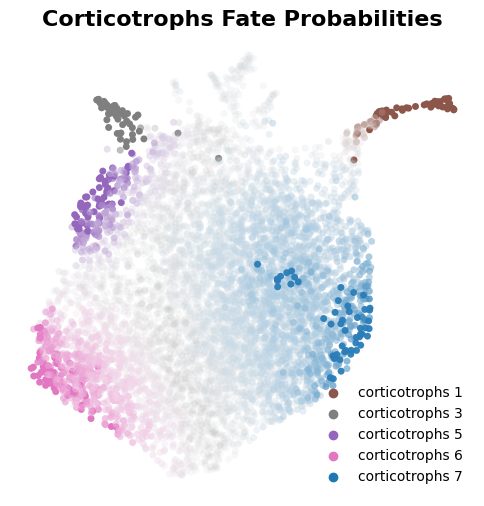

In [39]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False)
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
fig_kwargs = {"same_plot": True, 'legend_loc': 'best', 'dpi':600, 'size': 100, 
              "fontsize": 16, "ax":ax1, "show":False}
g.plot_fate_probabilities(**fig_kwargs)
ax1.set_title("Corticotrophs Fate Probabilities", fontweight="bold", fontsize=16)
pl.savefig("Fate_Probabilities.png", dpi=600)

<font size="5">Compute Lineage Gene Drivers</font>

In [40]:
driver_df= pd.DataFrame()
driver_df = g.compute_lineage_drivers(use_raw=True)
driver_df.to_csv("P3_merge_gene_drivers.csv")

Adding `adata.raw.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


In [41]:
g.compute_lineage_drivers( use_raw=True)

Adding `adata.raw.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


corticotrophs_1_corr  corticotrophs_1_pval  corticotrophs_1_qval  \
DIAPH3                  0.772889                   0.0                   0.0   
BRIP1                   0.715929                   0.0                   0.0   
POLQ                    0.688426                   0.0                   0.0   
DTL                     0.669183                   0.0                   0.0   
BRCA2                   0.615242                   0.0                   0.0   
...                          ...                   ...                   ...   
AC136616.1                   NaN                   NaN                   NaN   
AC136616.3                   NaN                   NaN                   NaN   
AC141272.1                   NaN                   NaN                   NaN   
AC023491.2                   NaN                   NaN                   NaN   
AC007325.1                   NaN                   NaN                   NaN   

            corticotrophs_1_ci_low  corticotrophs_1_ci_high  \
DIAPH3                    0.762769                 0.782631   
BRIP1                     0.703696                 0.727739   
POLQ                      0.675232                 0.701180   
DTL                       0.655340                 0.682576   
BRCA2                     0.599683                 0.630335   
...                            ...                      ...   
AC136616.1                     NaN                      NaN   
AC136616.3                     NaN                      NaN   
AC141272.1                     NaN                      NaN   
AC023491.2                     NaN                      NaN   
AC007325.1                     NaN                      NaN   

            corticotrophs_3_corr  corticotrophs_3_pval  corticotrophs_3_qval  \
DIAPH3                 -0.079509          2.409386e-10          1.041854e-08   
BRIP1                  -0.075875          1.521259e-09          5.704005e-08   
POLQ                   -0.071859          1.057872e-08          3.381075e-07   
DTL                    -0.072842          6.641161e-09          2.221727e-07   
BRCA2                  -0.057390          4.963366e-06          8.876227e-05   
...                          ...                   ...                   ...   
AC136616.1                   NaN                   NaN                   NaN   
AC136616.3                   NaN                   NaN                   NaN   
AC141272.1                   NaN                   NaN                   NaN   
AC023491.2                   NaN                   NaN                   NaN   
AC007325.1                   NaN                   NaN                   NaN   

            corticotrophs_3_ci_low  corticotrophs_3_ci_high  ...  \
DIAPH3                   -0.103960                -0.054961  ...   
BRIP1                    -0.100342                -0.051316  ...   
POLQ                     -0.096343                -0.047288  ...   
DTL                      -0.097323                -0.048274  ...   
BRCA2                    -0.081929                -0.032781  ...   
...                            ...                      ...  ...   
AC136616.1                     NaN                      NaN  ...   
AC136616.3                     NaN                      NaN  ...   
AC141272.1                     NaN                      NaN  ...   
AC023491.2                     NaN                      NaN  ...   
AC007325.1                     NaN                      NaN  ...   

            corticotrophs_6_corr  corticotrophs_6_pval  corticotrophs_6_qval  \
DIAPH3                 -0.183570          2.760769e-49          4.483681e-47   
BRIP1                  -0.173150          6.160834e-44          8.648077e-42   
POLQ                   -0.165848          2.181571e-40          2.626724e-38   
DTL                    -0.156458          4.615276e-36          4.688114e-34   
BRCA2                  -0.156426          4.766192e-36          4.823869e-34   
...                          ...    

In [42]:
# visualize and highlight gene drivers in a scatter plot
Tumor_genes = ["POMC",  "PPP1R17", "TBX19"]

genes_oi = {
    "Tumor Corticotrophs_2": Tumor_genes,
    
}


assert [
    gene in adata.var_names for genes in genes_oi.values() for gene in genes
], "Did not find all genes"



g.plot_lineage_drivers_correlation(
    lineage_y="Tumor Corticotrophs_2",
    lineage_x="Normal Corticotrophs_2",
    adjust_text=True,
    gene_sets=genes_oi,
    legend_loc="none",
    figsize=(5, 5),
    dpi=600,
    fontsize=9,
    size=50,
    use_raw=True,
    save="gene_corr.png"
)


<font size="5">Compute Latent Time</font>

In [46]:

scv.tl.recover_latent_time(adata,end_key='term_states_fwd_probs',root_key="init_states_fwd_probs")


computing terminal states
    identified 2 regions of root cells and 0 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


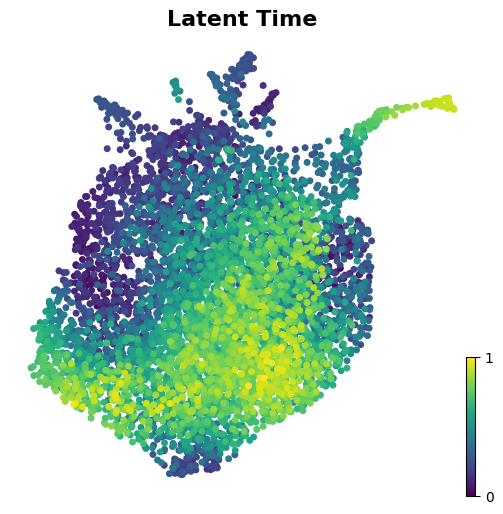

In [47]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = scv.pl.scatter(adata, color=['latent_time'], color_map='viridis', dpi=300, size=100, 
                          show = False, ax = ax1)
ax1.set_title("Latent Time", fontweight="bold", fontsize=16)
pl.savefig("Latent_Time.png")


<font size="5">Plot Lineage Gene Expression</font>

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Computing trends using `1` core(s)


  0%|          | 0/3 [00:00<?, ?gene/s]

    Finish (0:00:10)
Plotting trends


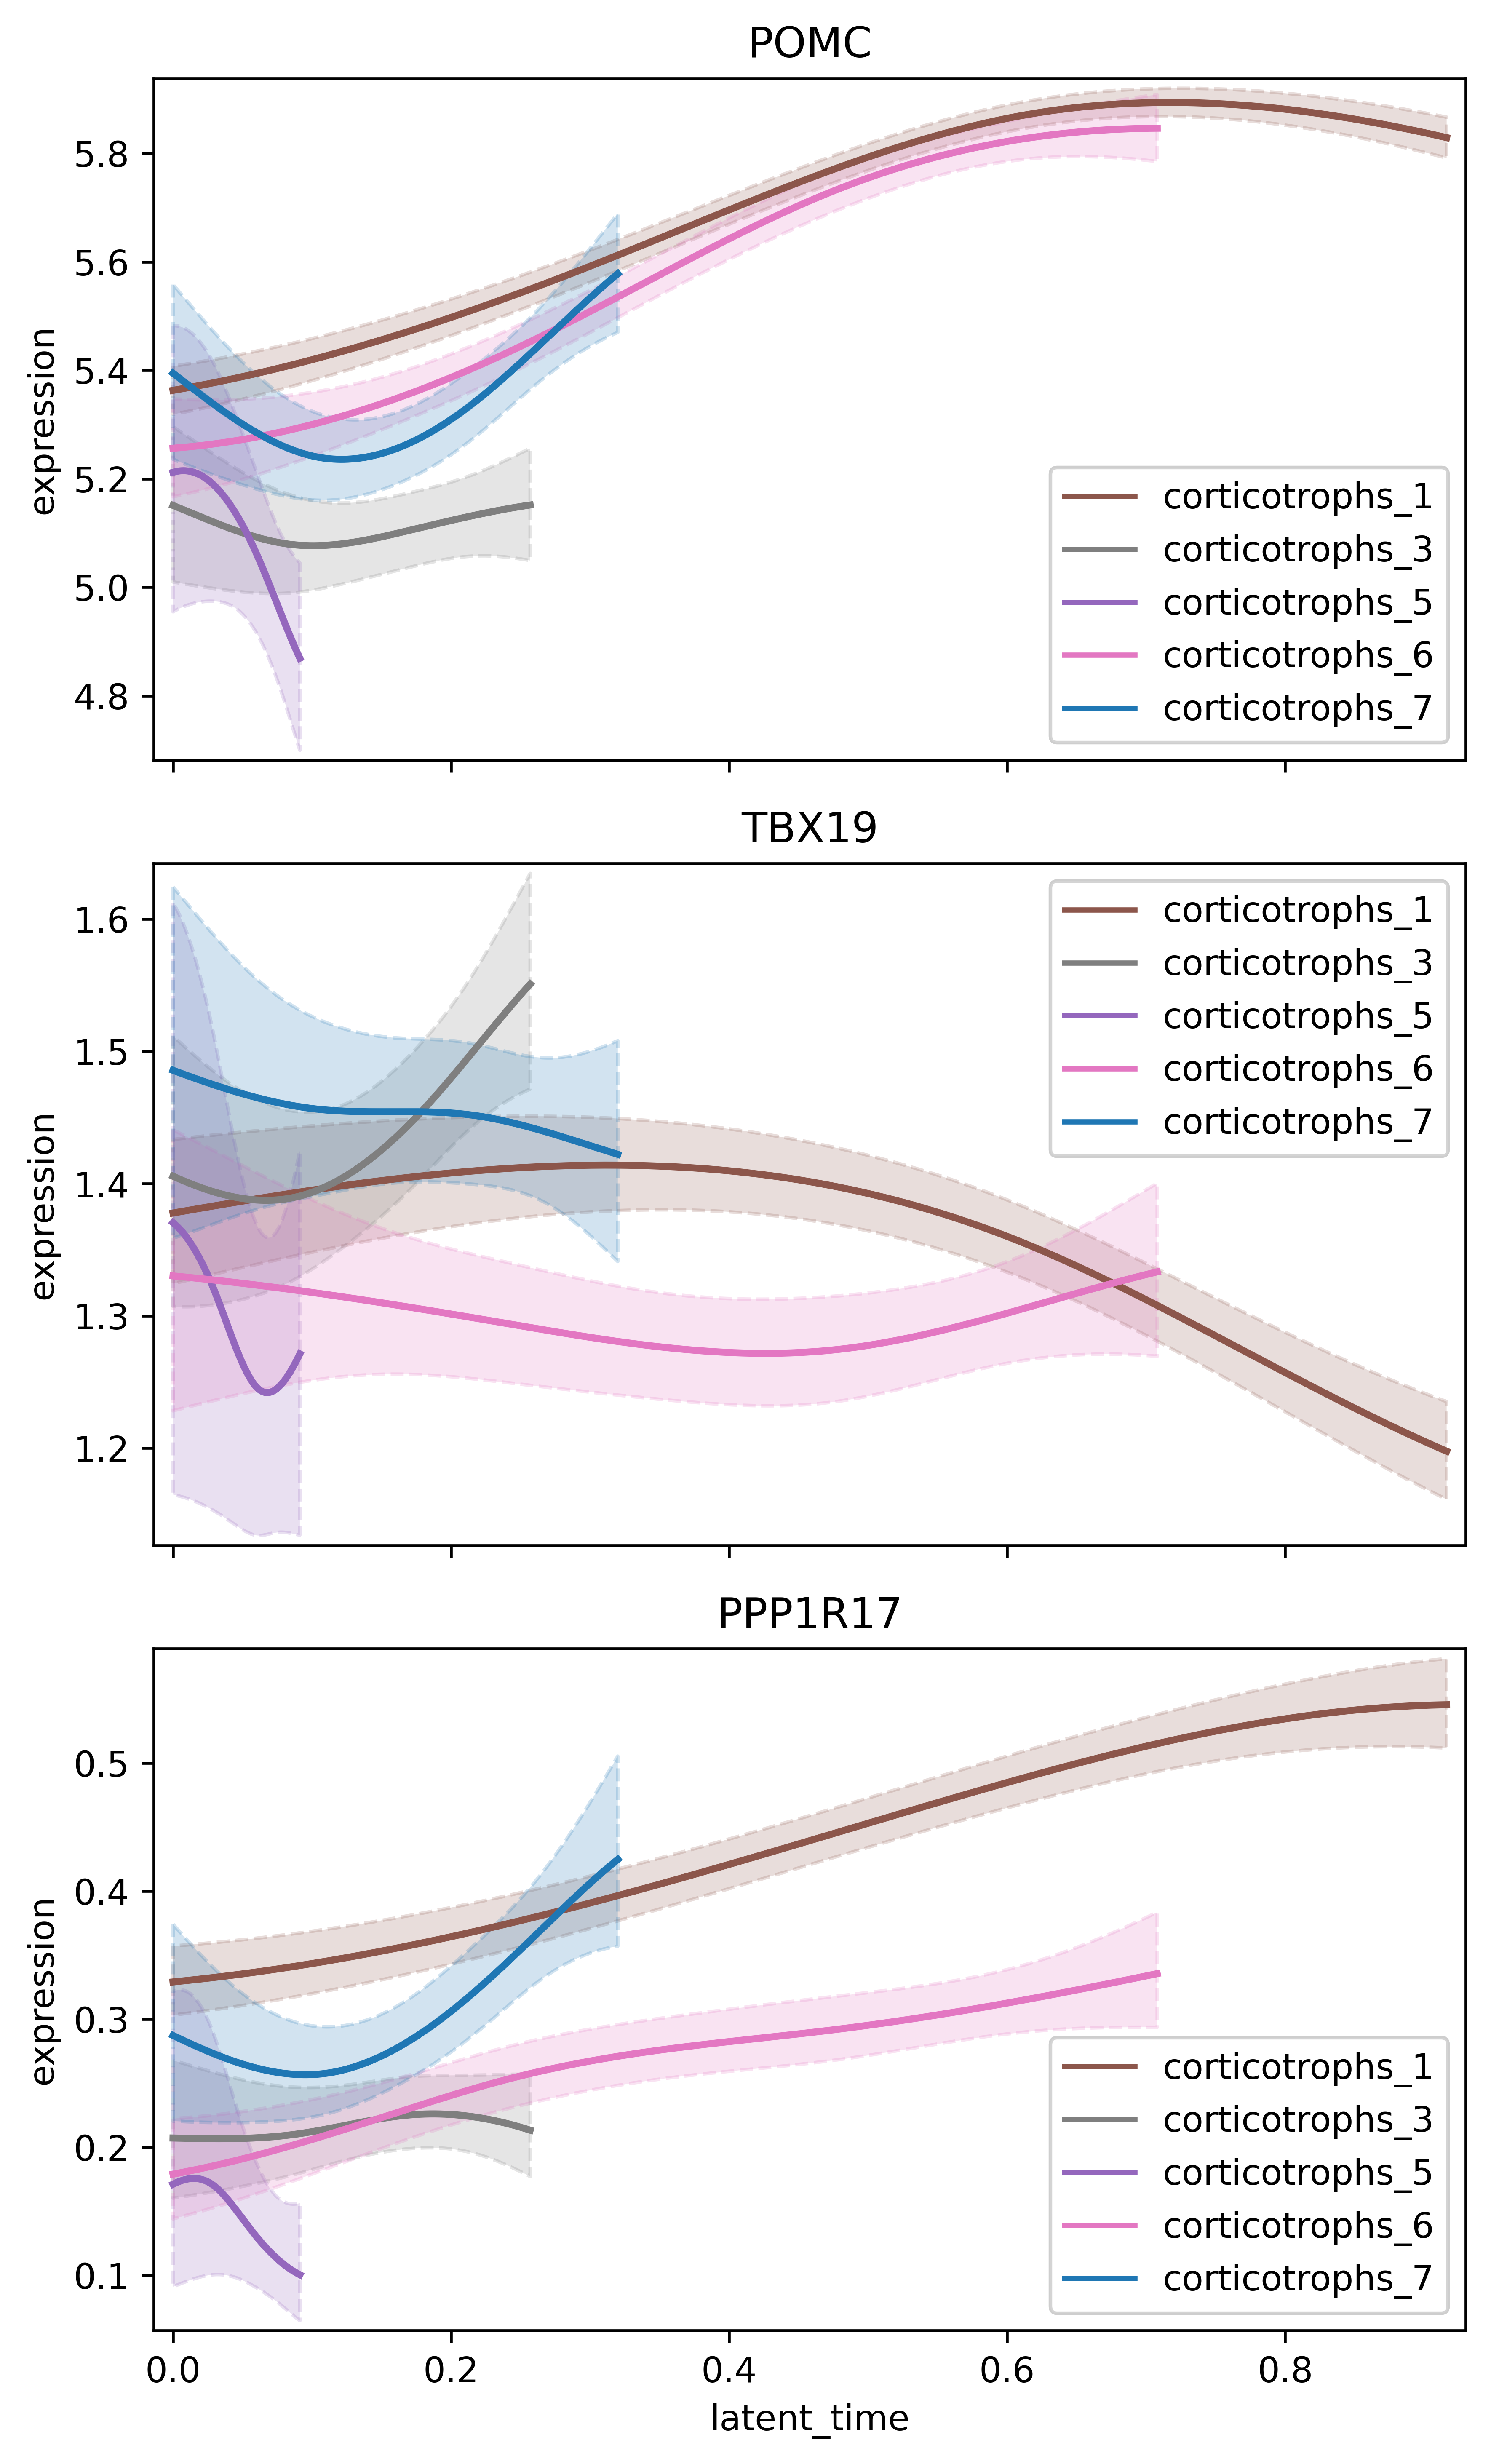

In [48]:
g.compute_lineage_drivers()
model = cr.models.GAM(adata)

cr.pl.gene_trends(
    adata,
    model=model,
    data_key="X",
    genes=["POMC", "TBX19",  "PPP1R17"],
    ncols=1,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(6,10),
    n_test_points=500,
    use_raw=True,
    legend_loc="best",
    dpi =600,
    save="gene_trends.png"
    
)